In [60]:
%load_ext autoreload
%autoreload 2
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
RESULT_JSON = "/Users/law/repos/viper/results/breakdown/breakdown.json"

In [165]:
from collections import defaultdict
runs = defaultdict(list)

BMS = get_all_runs(RESULT_JSON)

pprint(BMS)

[{'cpu_time': 170206670.441,
  'delete-lock': 7737021438.0,
  'delete-update': 4151713212.0,
  'delete-write': 4727565976.0,
  'get-fetch': 4441570736.0,
  'get-map': 8180735037.0,
  'get-read': 8832980730.0,
  'insert-lock': 7346605367.0,
  'insert-update': 9239260819.0,
  'insert-write': 14646917594.0,
  'items_per_second': 293025.6585938017,
  'iterations': 1,
  'name': 'ViperFixture<KeyType16,ValueType200>/breakdown/100000000/50000000/iterations:1/real_time/threads:1',
  'real_time': 170633524.85903305,
  'repetition_index': 0,
  'repetitions': 0,
  'run_name': 'ViperFixture<KeyType16,ValueType200>/breakdown/100000000/50000000/iterations:1/real_time/threads:1',
  'run_type': 'iteration',
  'threads': 1,
  'time_unit': 'us',
  'update-fetch': 4430619916.0,
  'update-map': 8210994676.0,
  'update-modify': 16901461490.0,
  'update-write': 4369892440.0},
 {'cpu_time': 10577996.381944446,
  'delete-lock': 13705006716.0,
  'delete-update': 11010907760.0,
  'delete-write': 9725961343.0,
 

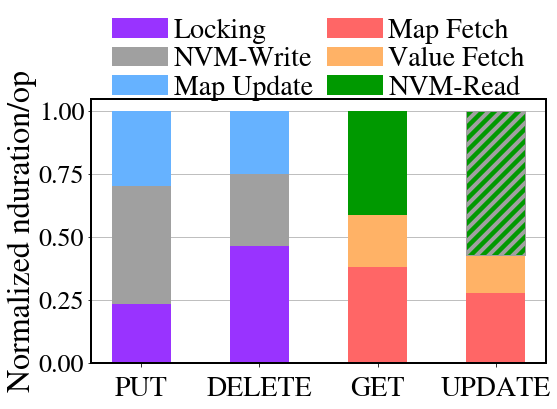

In [213]:
INSERT_TIMERS = ("insert-lock", "insert-update", "insert-write")
GET_TIMERS = ("get-fetch", "get-map", "get-read")
UPDATE_TIMERS = ("update-fetch", "update-map", "update-modify") #, "update-write")
DELETE_TIMERS = ("delete-lock", "delete-update", "delete-write")
ALL_TIMERS = (*INSERT_TIMERS, *GET_TIMERS, *UPDATE_TIMERS, *DELETE_TIMERS)

def get_sum_time(bm, timers):
    total_ns = 0
    for timer in timers:
        total_ns += bm[timer]
    return total_ns

st_bm = BMS[0]
at_bm = BMS[1]

st_insert = get_sum_time(BMS[0], INSERT_TIMERS)
st_get = get_sum_time(BMS[0], GET_TIMERS)
st_update = get_sum_time(BMS[0], UPDATE_TIMERS)
st_delete = get_sum_time(BMS[0], DELETE_TIMERS)
at_insert = get_sum_time(BMS[1], INSERT_TIMERS)
at_get = get_sum_time(BMS[1], GET_TIMERS)
at_update = get_sum_time(BMS[1], UPDATE_TIMERS)
at_delete = get_sum_time(BMS[1], DELETE_TIMERS)

bar_width = 0.50
st_pos = np.arange(4)
al_pos = [x + bar_width for x in st_pos]
POS = [st_pos, al_pos]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ALL_RUNS = [(st_bm, st_insert, st_get, st_update, st_delete)] #, (at_bm, at_insert, at_get, at_update, at_delete)]
for i, (bm, insert, get, update, delete) in enumerate(ALL_RUNS):
    # INSERT
    insert_lock = bm["insert-lock"] / insert
    insert_write = bm["insert-write"] / insert
    insert_update = bm["insert-update"] / insert
    ax.bar(POS[i][0], insert_lock, bar_width, bottom=0, color='#9933FF', label="Locking")
    ax.bar(POS[i][0], insert_write, bar_width, bottom=insert_lock, color='#A0A0A0', label="NVM-Write")
    ax.bar(POS[i][0], insert_update, bar_width, bottom=insert_lock + insert_write, color='#66B2FF', label="Map Update")
    
    # DELETE
    delete_lock = bm["delete-lock"] / delete
    delete_write = bm["delete-write"] / delete
    delete_update = bm["delete-update"] / delete
    ax.bar(POS[i][1], delete_lock, bar_width, bottom=0, color='#9933FF')
    ax.bar(POS[i][1], delete_write, bar_width, bottom=delete_lock, color='#A0A0A0')
    ax.bar(POS[i][1], delete_update, bar_width, bottom=delete_lock + delete_write, color='#66B2FF')
    
    # GET
    get_map = bm["get-map"] / get
    get_fetch = bm["get-fetch"] / get
    get_read = bm["get-read"] / get
    ax.bar(POS[i][2], get_map, bar_width, bottom=0, color='#FF6666', label="Map Fetch")
    ax.bar(POS[i][2], get_fetch, bar_width, bottom=get_map, color='#FFB266', label="Value Fetch")
    ax.bar(POS[i][2], get_read, bar_width, bottom=get_map + get_fetch, color='#009900', label="NVM-Read")
    
    # UPDATE
    update_map = bm["update-map"] / update
    update_fetch = bm["update-fetch"] / update
    update_modify = bm["update-modify"] / update
    update_write = bm["update-write"] / update
    ax.bar(POS[i][3], update_map, bar_width, bottom=0, color='#FF6666')
    ax.bar(POS[i][3], update_fetch, bar_width, bottom=update_map, color='#FFB266')
    ax.bar(POS[i][3], update_modify, bar_width, bottom=update_map + update_fetch, color='#009900',
          hatch='//', edgecolor='#A0A0A0')
#     ax.bar(POS[i][3], update_write, bar_width, bottom=update_map + update_fetch + update_modify, color='#A0A0A0')

rcParams['hatch.linewidth'] = 4.0 


ax.set_xticks([r + (0.0 * bar_width) for r in st_pos])
ax.xaxis.set_tick_params(pad=10)
ax.set_xticklabels(["PUT", "DELETE", "GET", "UPDATE"], fontsize=28)

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

ax.set_ylabel("Normalized nduration/op", fontsize=32)
ax.yaxis.set_label_coords(-0.12, 0.5)

ax.legend(frameon=False, loc='upper center',
          bbox_to_anchor=(0.5, 1.4), 
          ncol=2, fontsize=28,
          columnspacing=0.5, handletextpad=0.2, labelspacing=0.1)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)

ax.set_axisbelow(True)
ax.grid(axis='y', which='major')
fig.savefig('charts/breakdown.pdf', bbox_inches='tight')
fig.savefig('charts/breakdown.svg', bbox_inches='tight')